# Import Packages

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import json

from modules.models import KMeansModels, KMeansModelConfig 
from constants import (
    PRODUCT_TEST_EMBEDDINGS_PATH, 
    CLASS_EMBEDDINGS_PATH, 
    RANDOM_STATE, 
    DEVICE, 
    CLEANED_GPC_PATH,
    CLEANED_TEST_DATA_PATH,
    DATA_PATH
)

## Read CSVs

In [2]:
df_products_embeddings = pd.read_csv(PRODUCT_TEST_EMBEDDINGS_PATH)
df_classes_embeddings = pd.read_csv(CLASS_EMBEDDINGS_PATH)

df_classes = pd.read_csv(CLEANED_GPC_PATH)
df_products = pd.read_csv(CLEANED_TEST_DATA_PATH)

In [3]:
df_products = pd.merge(df_products, df_products_embeddings, on="id")
df_classes = pd.merge(df_classes, df_classes_embeddings, on="id")

## Load Embeddings

In [4]:
products_embeddings = [json.loads(embedding) for embedding in df_products["embeddings"].tolist()]
classes_embeddings = [json.loads(embedding) for embedding in df_classes["embeddings"].tolist()]

## Visualize Embeddings

### Products Embeddings

In [6]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=400, random_state=RANDOM_STATE)
products = tsne.fit_transform(np.array(products_embeddings))

C:\Users\os255022\AppData\Local\Temp\ipykernel_32292\3692365185.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(products[:, 0], products[:, 1], cmap="viridis", s=0.5)


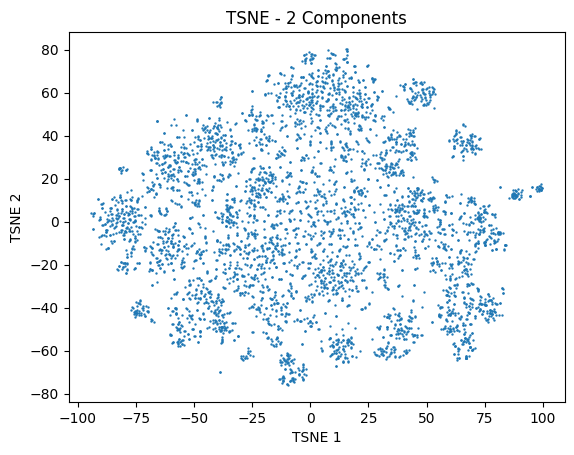

In [7]:
plt.scatter(products[:, 0], products[:, 1], cmap="viridis", s=0.5)

plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE - 2 Components")
plt.show()

C:\Users\os255022\AppData\Local\Temp\ipykernel_32292\2202810288.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(products[:, 0], products[:, 1], cmap="viridis", s=0.5)


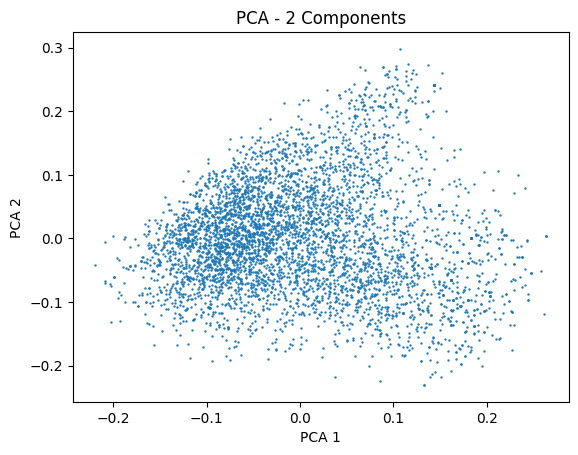

In [5]:
pca = PCA(2)
products = pca.fit_transform(products_embeddings)

plt.scatter(products[:, 0], products[:, 1], cmap="viridis", s=0.5)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA - 2 Components")
plt.show()

### Classes Embeddings

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=400, random_state=RANDOM_STATE)
classes = tsne.fit_transform(np.array(classes_embeddings))

plt.scatter(classes[:, 0], classes[:, 1], cmap="viridis")

plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE - 2 Components")
plt.show()

## Model

### Find Best Number of Clusters

Numberof K: 41


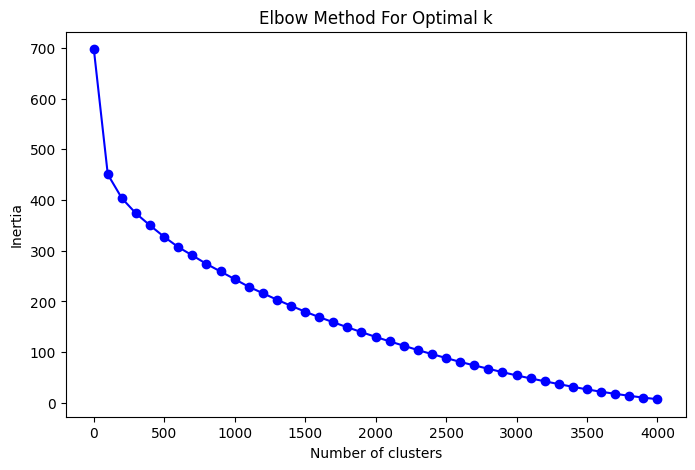

In [28]:

inertia = []
K = [1] + list(range(100, 4001, 100))
print(f"Numberof K: {len(K)}")

for k in K:
    config = KMeansModelConfig(n_clusters=k, model_name=None)
    kmeans = KMeansModels(config)
    kmeans.fit(products_embeddings.tolist() if isinstance(products_embeddings, torch.Tensor) else products_embeddings)
    inertia.append(kmeans.model.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


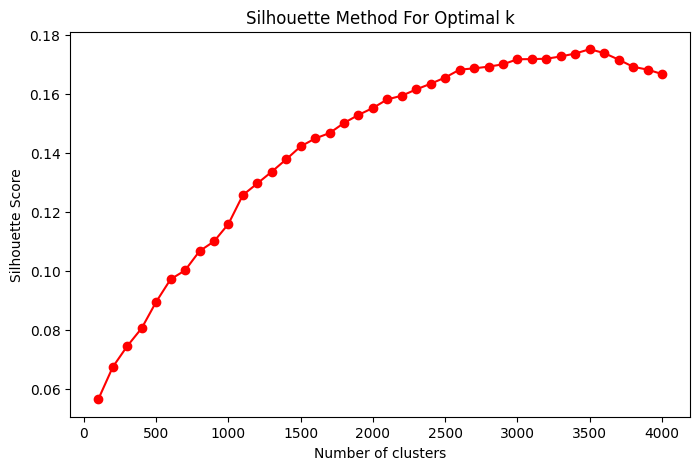

In [30]:
sil_scores = []
products_embeddings = products_embeddings.tolist()

for k in K:
    config = KMeansModelConfig(n_clusters=k)
    kmeans = KMeansModels(config)
    kmeans.fit(products_embeddings)
    labels = kmeans.model.predict(products_embeddings)
    if len(set(labels)) <= 1:
        continue
    sil_score = silhouette_score(products_embeddings, labels)
    sil_scores.append(sil_score)

plt.figure(figsize=(8,5))
plt.plot(K[1:], sil_scores, 'ro-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()


### Load Model

In [17]:
n_clusters = 50
config = KMeansModelConfig(n_clusters=n_clusters, topk=2)
kmeans = KMeansModels(config)

### Get Predictions

#### Centroid Approach

In [12]:
kmeans.fit(products_embeddings)
classes_embeddings = torch.tensor(classes_embeddings, dtype=torch.float16, device=DEVICE)
products_embeddings = torch.tensor(products_embeddings, dtype=classes_embeddings.dtype, device=classes_embeddings.device)
centroid_classes = kmeans.get_centroid_classes(classes_embeddings)

0it [00:00, ?it/s]

In [13]:
cluster_items = kmeans.get_cluster_items(products_embeddings)
cluster_items_dict = {key: {id for id, _ in value} for key, value in cluster_items.items()}

In [14]:
class_names_list = []
num_products = len(df_products)
for i in range(num_products):
    for cluster_num, products in cluster_items_dict.items():
        if i not in products:
            continue
        class_id = centroid_classes[cluster_num].tolist()[0]
        class_names_list.append(df_classes[df_classes["id"]==class_id].values[0][2])

df_products["prediction"] = class_names_list

ValueError: ('Lengths must match to compare', (185440,), (4,))

In [ ]:
df_products.to_csv(DATA_PATH / "kmeans_centroid_predection.csv", index=False, encoding="utf-8-sig")

#### Cluster Approach

In [ ]:
import statistics
from collections import Counter

K = [1] + list(range(5, 101, 5))

for k in K:
    config = KMeansModelConfig(n_clusters=k, topk=None)
    kmeans = KMeansModels(config)  
    kmeans.fit(products_embeddings.tolist())
    classes_embeddings = torch.tensor(classes_embeddings, dtype=torch.float16, device=DEVICE)
    products_embeddings = torch.tensor(products_embeddings, dtype=classes_embeddings.dtype, device=classes_embeddings.device)
    clusters_class = kmeans.get_cluster_classes(products_embeddings, classes_embeddings)
    confidince_rates = [v[3] for _, v in clusters_class.items()]
    print(f"The confidance rate of {k} clusters: {statistics.mean(confidince_rates)}")
    classes = [v[0] for _, v in clusters_class.items()]
    counts = Counter(classes)
    repeated = [cnt for _, cnt in counts.items() if cnt > 1]
    print(f"The number of times classes were repeated for {k} clusters: {sum(repeated)}")

In [18]:
kmeans.fit(products_embeddings.tolist())
classes_embeddings = torch.tensor(classes_embeddings, dtype=torch.float16, device=DEVICE)
products_embeddings = torch.tensor(products_embeddings, dtype=classes_embeddings.dtype, device=classes_embeddings.device)
clusters_class = kmeans.get_cluster_classes(products_embeddings, classes_embeddings)
confidince_rates = [v[3] for _, v in clusters_class.items()]
print(f"The confidance rate of {n_clusters} clusters: {statistics.mean(confidince_rates)}")

C:\Users\os255022\AppData\Local\Temp\ipykernel_32292\1946117448.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classes_embeddings = torch.tensor(classes_embeddings, dtype=torch.float16, device=DEVICE)
C:\Users\os255022\AppData\Local\Temp\ipykernel_32292\1946117448.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  products_embeddings = torch.tensor(products_embeddings, dtype=classes_embeddings.dtype, device=classes_embeddings.device)


  0%|          | 0/50 [00:00<?, ?it/s]

The confidance rate of 50 clusters: 0.14365285328227007


In [19]:
clusters_class

{0: (175307, 14, 134, 0.1044776119402985),
 1: (41345, 9, 126, 0.07142857142857142),
 2: (163904, 37, 106, 0.3490566037735849),
 3: (40301, 70, 264, 0.26515151515151514),
 4: (69089, 15, 236, 0.0635593220338983),
 5: (165894, 21, 136, 0.15441176470588236),
 6: (87995, 12, 120, 0.1),
 7: (43676, 118, 290, 0.4068965517241379),
 8: (3851, 12, 78, 0.15384615384615385),
 9: (43676, 16, 108, 0.14814814814814814),
 10: (15576, 12, 270, 0.044444444444444446),
 11: (99848, 35, 136, 0.25735294117647056),
 12: (43676, 11, 152, 0.07236842105263158),
 13: (14485, 31, 252, 0.12301587301587301),
 14: (39068, 9, 116, 0.07758620689655173),
 15: (43372, 18, 196, 0.09183673469387756),
 16: (40580, 15, 222, 0.06756756756756757),
 17: (104719, 34, 150, 0.22666666666666666),
 18: (174346, 37, 320, 0.115625),
 19: (24676, 9, 98, 0.09183673469387756),
 20: (173546, 7, 150, 0.04666666666666667),
 21: (170334, 6, 140, 0.04285714285714286),
 22: (164160, 23, 62, 0.3709677419354839),
 23: (104697, 24, 404, 0.0594

In [20]:
cluster_items = kmeans.get_cluster_items(products_embeddings)

In [23]:
cluster_id = 0
class_id = clusters_class[cluster_id][0]
df_classes[df_classes["id"]==class_id]["class_name_cleaned"].values[0]

'lawn garden supplies watering equipment cans'

In [24]:
product_id = cluster_items[cluster_id][2][0]
df_products[df_products["id"]==product_id]

,id,Item_Name,translated_text,cleaned_text,embeddings
572,572,علبه كمامه ايفوني,A box of iPhone muzzles.,a box of iphone muzzles,"[0.026763916015625, 0.03155517578125, -0.04492..."
